## BE485, Lab 13, Ex 2: NDVI Phenology
 In this exercise:<br>
 a) Read a Year of NDVI data<br>
 b) Compute Phenoloy Metrics by Pixel Timeseries and for Image<br>
     - Start of the Season (SOS)
     - End of the Season (EOS)
     - Day of Peak (DOP)
 c) Plot and Display metrics
    

    

In [1]:
# Import all necessary libraries

import os
import matplotlib.pyplot as plt
import numpy as np

# Library for reading HDF files
from pyhdf.SD import SD, SDC

#Import the VIP Library
import viplab_lib5 as vip

# This is a magic function call that renders the figure in a notebook
# instead of displaying a dump of the figure object
%matplotlib inline

# display current working directory
print (os.getcwd())

C:\Users\theboss\BE485\Lab\Lab-13-Code


## User defined functions

In [2]:
# user defined functions


#custom function to read NDVI and RANK
#and calculate NDVI
def HDFread_VIS(filename,showfname=True):
    
    if(showfname):
       print("Reading ",filename)
          
    hdf = SD(filename, SDC.READ)
    sdsNDVI= hdf.select('1 km 16 days NDVI')
    bandNDVI=sdsNDVI.get()
    sdsRANK= hdf.select('1 km 16 days pixel reliability')
    bandRANK=sdsRANK.get()
    
    hdf.end()
    return bandNDVI, bandRANK


def getDOY(index):
    days=[1,17,33,49,65,81,97,113,129,145,161,177,193,209,225,241,257,273,289,305,321,337,353] 
    DOY=-1
    
    if(index>-1):
        if(index>22):
            index=index-22
        DOY=days[index]    
    
    return DOY


def NDVI_smooth(NDVIlist,p=2):
    n=len(NDVIlist)
   
    NDVIsmooth=[]    
    for i in range(0,n):
     
       sum=0
       kcount=0
       for k in range(0,p*2):
         j=k-p+i
         if(j>=0 and j<n):
             value=NDVIlist[j]
             sum=sum+value
             kcount=kcount+1
         elif(j>=n):
             j=n-j
             value=NDVIlist[j]
             sum=sum+value
             kcount=kcount+1
             
             
       if(kcount>0):
          avg=sum/kcount
       else:
           avg=-1500
       NDVIsmooth.append(avg)
    
    return NDVIsmooth

#this phenology function only works for 1 season timeseries
#it assumes threshold lines only intersects 2 times the NDVI curve    
def Pixel_Phenology(NDVIList,NDVIThreshold):
    
    NDVIlist=NDVIList.copy() #make a copy of data
    #Trick: Repeat first day at the end to not miss intersections
    NDVIlist.append(NDVIlist[0])
    
    #Initialize variables
    StartSeason=-1
    EndSeason=-1
    DayOfPeak=-1
    
    n=len(NDVIlist)
    
    #identify Peak of Season
    NDVIMax=max(NDVIlist)
    if(NDVIMax>0):
        for i in range(0,n):
           if(NDVIlist[i]==NDVIMax):
               DayOfPeak=i
     
        
    if(DayOfPeak>-1):    
      #look for SOS and EOS
      #intersection of with thresholds
      for i in range(0,n-1):
         v1=NDVIlist[i]
         v2=NDVIlist[i+1]
         half=(v2+v1)/2
        
         if(NDVIThreshold>=v1 and NDVIThreshold<v2):
             if(NDVIThreshold>=v1 and NDVIThreshold<half):
                StartSeason=i
             else:
                StartSeason=i+1
         if(NDVIThreshold>=v2 and NDVIThreshold<v1):
             if(NDVIThreshold>=v2 and NDVIThreshold<half):
                EndSeason=i+1
             else:
                EndSeason=i
    
    if(StartSeason==-1 or EndSeason==-1):
        DayOfPeak=-1
    
    return StartSeason,EndSeason,DayOfPeak


def Band_Phenology(NDVIArray):
    nrows,ncols,nlayers=NDVIArray.shape
    
    bandSOS=np.zeros((nrows,ncols),np.int16)
    bandEOS=np.zeros((nrows,ncols),np.int16)
    bandDOP=np.zeros((nrows,ncols),np.int16)
    for i in range(0,nrows):
        for j in range(0,ncols):
            
            y1=NDVIArray[i,j,:]
            y1=np.resize(y1,(24,)) # repeat the first value at the end
            y1smooth=NDVI_smooth(y1)
            
            NDVImin=y1.min()
            NDVImax=y1.max()
            #halfMax threshold for Phenology
            halfMax=(NDVImax+NDVImin)/2
            
            SOS,EOS,DOP=Pixel_Phenology(y1smooth,halfMax)
            
            bandSOS[i,j]=getDOY(SOS)
            bandEOS[i,j]=getDOY(EOS)
            bandDOP[i,j]=getDOY(DOP)
    
    return bandSOS,bandEOS,bandDOP


## Main program starts here !
## 1. Define and read input data file

In [3]:
# start of main script

# define input data

# MODIS Files
# index: datatype : band name
#  0 : INT16  : 1 km 16 days NDVI
#  1 : UINT16 : 1 km 16 days VI Quality
#  2 : INT16  : 1 km 16 days composite day of the year
#  3 : INT8   : 1 km 16 days pixel reliability

nrows=300
ncols=300
FILL_VI=-3000
fmulti=0.0001
NDVImin=-2000
NDVImax=10000

CYCLES_YEAR=23
NYEARS=1
NLAYERS=CYCLES_YEAR * NYEARS


#create band arrays to store 16day composite images images
NDVICube=np.zeros((nrows,ncols,NLAYERS),np.int16)
RANKCube=np.zeros((nrows,ncols,NLAYERS),np.int8)     

#list of days (16days composited) for a Year
DOYList=['001','017','033','049','065','081','097','113','129','145','161','177',
         '193','209','225','241','257','273','289','305','321','337','353']


#folder where data is stored
dataPath='./data_C16/'


startTime=vip.startTime()
k=0

YEAR=2019
print("Reading NDVI (16 days composited files )data for year ",YEAR)

for i in range(0,23):
        DOY=DOYList[i]
        
        #read HDF bands 
        filename=dataPath+'MOD13A2.A'+str(YEAR)+DOY+'.h08v05.006.subset.hdf'
        NDVI,RANK=HDFread_VIS(filename)
        
        #store in daily array
        NDVICube[:,:,k]=NDVI
        RANKCube[:,:,k]=RANK
        k=k+1
    
vip.endTime(startTime,"Reading complete:") 



Reading NDVI (16 days composited files )data for year  2019
Reading  ./data_C16/MOD13A2.A2019001.h08v05.006.subset.hdf
Reading  ./data_C16/MOD13A2.A2019017.h08v05.006.subset.hdf
Reading  ./data_C16/MOD13A2.A2019033.h08v05.006.subset.hdf
Reading  ./data_C16/MOD13A2.A2019049.h08v05.006.subset.hdf
Reading  ./data_C16/MOD13A2.A2019065.h08v05.006.subset.hdf
Reading  ./data_C16/MOD13A2.A2019081.h08v05.006.subset.hdf
Reading  ./data_C16/MOD13A2.A2019097.h08v05.006.subset.hdf
Reading  ./data_C16/MOD13A2.A2019113.h08v05.006.subset.hdf
Reading  ./data_C16/MOD13A2.A2019129.h08v05.006.subset.hdf
Reading  ./data_C16/MOD13A2.A2019145.h08v05.006.subset.hdf
Reading  ./data_C16/MOD13A2.A2019161.h08v05.006.subset.hdf
Reading  ./data_C16/MOD13A2.A2019177.h08v05.006.subset.hdf
Reading  ./data_C16/MOD13A2.A2019193.h08v05.006.subset.hdf
Reading  ./data_C16/MOD13A2.A2019209.h08v05.006.subset.hdf
Reading  ./data_C16/MOD13A2.A2019225.h08v05.006.subset.hdf
Reading  ./data_C16/MOD13A2.A2019241.h08v05.006.subset.

## 2. Compute Phenology Metrics and Plot NDVI Timeseries for a Pixel

Smoothing and Plotting NDVI Timeseries for a pixel

 NDVI Phenology for pixel [226,247] YEAR 2019
Start of Season= 113
Day of Peak= 241
End of Season= 353


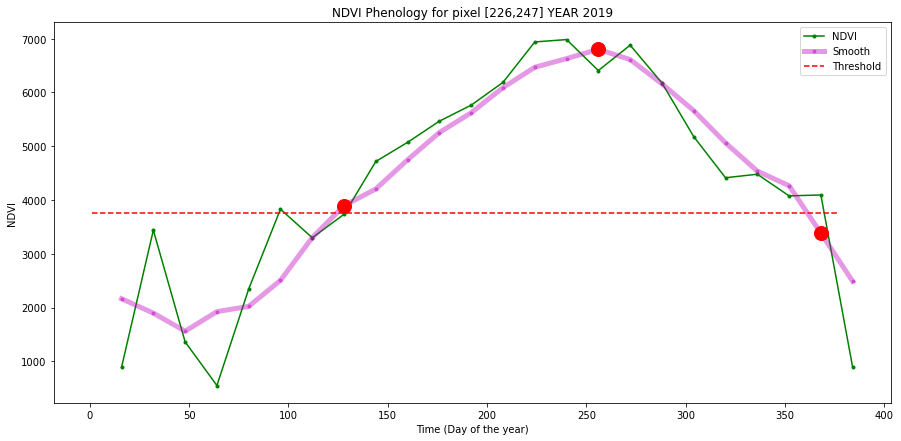

In [11]:
print("Smoothing and Plotting NDVI Timeseries for a pixel")
plt.figure(figsize=(15,7))

#Pixel Forest, this pixel will be used to trace the processing
#row=152
#col=184

row=226
col=247

#Prepare arrays for plotting
x=np.linspace(1,24,num=24)*16
y1=NDVICube[row,col,:]
y1=np.resize(y1,(24,)) # repeat the first value at the end

y1smooth=NDVI_smooth(y1)


NDVImin=y1.min()
NDVImax=y1.max()

#halfMax threshold for Phenology
halfMax=(NDVImax+NDVImin)/2

#compute phenology
StartSeason,EndSeason,DayOfPeak=Pixel_Phenology(y1smooth,halfMax)

if(StartSeason!=-1 and EndSeason!=-1):
 
  #retrieve NDVI values for metric's days
  PhenoX=[x[StartSeason], x[DayOfPeak], x[EndSeason]]
  PhenoY=[y1smooth[StartSeason], y1smooth[DayOfPeak], y1smooth[EndSeason]]
    
  #get day of year from cycle id   
  StartSeason=getDOY(StartSeason)
  DayOfPeak=getDOY(DayOfPeak)
  EndSeason=getDOY(EndSeason) 
  foundPhenology=True
else:
  foundPhenology=False  

title='NDVI Phenology for pixel ['+str(row)+','+str(col)+'] YEAR '+str(YEAR)

plt.plot(x,y1,'-g.',label='NDVI')
plt.plot(x,y1smooth,'-m.',label='Smooth',linewidth=5,alpha=.4)
plt.plot([1,376],[halfMax,halfMax],'r--',label='Threshold')
plt.legend(loc='upper right')
plt.title(title)
plt.ylabel('NDVI')
plt.xlabel('Time (Day of the year)')

print("\n",title)

if(foundPhenology==True):
    plt.plot(PhenoX,PhenoY,'ro',markersize=14)
    print("Start of Season=",StartSeason)
    print("Day of Peak=",DayOfPeak) 
    print("End of Season=", EndSeason)
     
else :
    print("Algorithm was not able to compute metrics")


## 3. Phenology Metrics for full Image

In [12]:
print("Estimating Phenology metrics for full image..., YEAR=",YEAR)
startTime=vip.startTime()
bandSOS,bandEOS,bandDOP=Band_Phenology(NDVICube)
vip.endTime(startTime,"Done:") 



Estimating Phenology metrics for full image..., YEAR= 2019
Done: 12.23  seconds


## 4. Plot the Phenolog Metrics Images

Plotting Phenology metrics...
 0.47  seconds
Phenology Metrics for Year: 2019


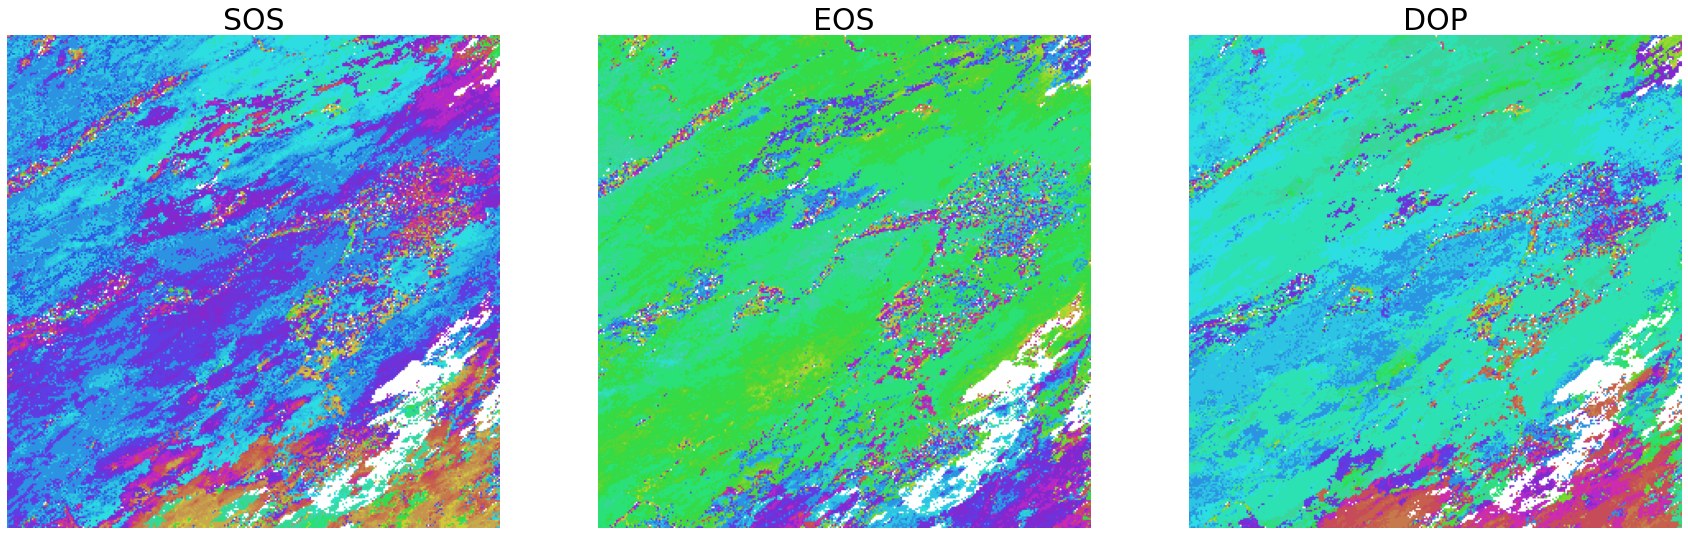

In [13]:
#Plot the Metrics
print("Plotting Phenology metrics...")
startTime=vip.startTime()
#use a LUT color file for days
LutSOS=vip.LUT_load('PhenoSOS_EOS.dsr')
LutDOP=vip.LUT_load('PhenoDOP.dsr')

#plt.figure(figsize=(30,10))
f, plot = plt.subplots(ncols=3,figsize=(30,10))
ImageLUT=vip.getImage_fromLUT(bandSOS,LutSOS)
plot[0].imshow(ImageLUT)
plot[0].set_title('SOS',fontsize=30)
plot[0].axis('off') 

ImageLUT=vip.getImage_fromLUT(bandEOS,LutSOS)
plot[1].imshow(ImageLUT)
plot[1].set_title('EOS',fontsize=30)
plot[1].axis('off') 

ImageLUT=vip.getImage_fromLUT(bandDOP,LutDOP)
plot[2].imshow(ImageLUT)
plot[2].set_title('DOP',fontsize=30)
plot[2].axis('off') 

vip.endTime(startTime)

print("Phenology Metrics for Year:",YEAR)

<table>
<tr>
    <td>
        <img src="https://vip.arizona.edu/kml/SOS_Legend.png"/>
    </td>
    <td>
        <img src="https://vip.arizona.edu/kml/EOS_Legend.png"/>
    </td>
    <td>
        <img src="https://vip.arizona.edu/kml/DOP_Legend.png"/>
    </td>
</tr>
</table>

## 6. Homework (see presentation)
### Compute Length of the Season Image (LOS)

In [14]:
# put here your code
#hint: keep in mind that for some pixels SOS > EOS

### b) Display your LOS image (use the PhenoLOS.dsr color table)

In [15]:
#put here your code




<img src="https://vip.arizona.edu/kml/LOS_Legend.png"/>

### c) Compute Phenology for Year 2001, 2005, 2010, 2015 and 2019 for a Pixel, display the metrics and plot them

In [16]:
#put your code here
#describe what you see!



In [17]:
print("program ended.")

program ended.
